# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.80,0.10,0.10))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:22, 51.40 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 108 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 111 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 103 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 106 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 859 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 879 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 813 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 838 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 107 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.RandomRotation(0.2),
    # preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [8]:
epoch = 20
batchsize = 16

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [23]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [24]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

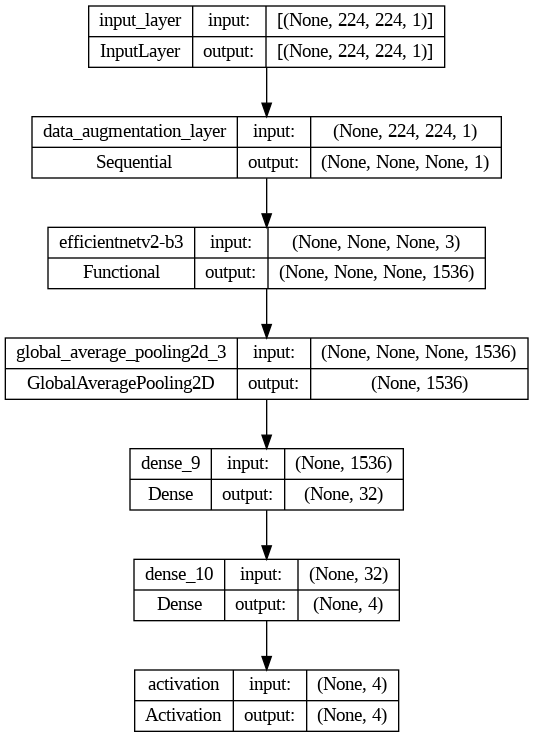

In [26]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [27]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [28]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 73s 288ms/step - loss: 0.6730 - accuracy: 0.7347 - val_loss: 0.6270 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 49s 233ms/step - loss: 0.5041 - accuracy: 0.7988 - val_loss: 0.4647 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 43s 201ms/step - loss: 0.4604 - accuracy: 0.8283 - val_loss: 0.4550 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 38s 180ms/step - loss: 0.4247 - accuracy: 0.8392 - val_loss: 0.4808 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 36s 170ms/step - loss: 0.4119 - accuracy: 0.8433 - val_loss: 0.4369 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 32s 152ms/step - loss: 0.3756 - accuracy: 0.8560 - val_loss: 0.4658 - val_accuracy: 0.8337 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

EfficientNetV2B3 Evaluation

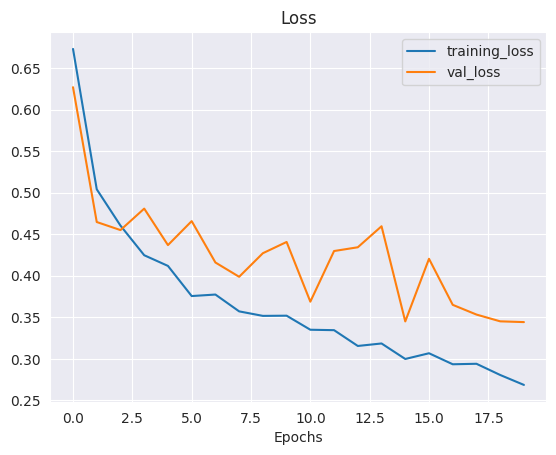

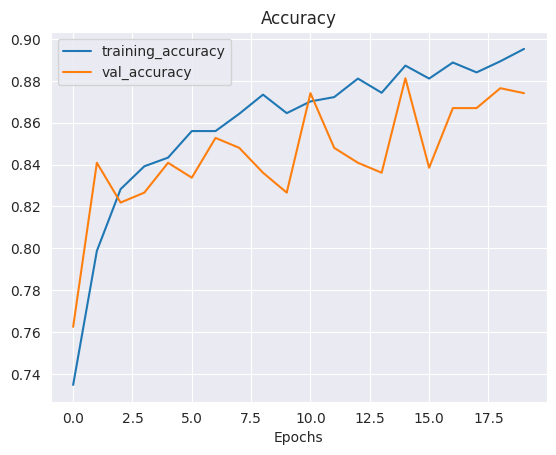

In [29]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       106
           1       0.96      0.99      0.98       111
           2       0.93      0.76      0.83       103
           3       0.84      0.91      0.87       108

    accuracy                           0.90       428
   macro avg       0.91      0.90      0.90       428
weighted avg       0.91      0.90      0.90       428

Specificity: [0.308868501529052, 0.34591194968553457, 0.22285714285714286, 0.296969696969697]
Mean Squared Error: : 0.1115582287311554
The average AUC-ROC is 0.9874995840320075


[0.9841269841269841,
 0.6624203821656051,
 0.6947674418604651,
 0.6720257234726688,
 0.6476190476190476,
 0.9968152866242038,
 0.6773255813953488,
 0.6463022508038585,
 0.7015873015873015,
 0.678343949044586,
 0.9273255813953488,
 0.7138263665594855,
 0.6666666666666666,
 0.6624203821656051,
 0.7005813953488372,
 0.9678456591639871]

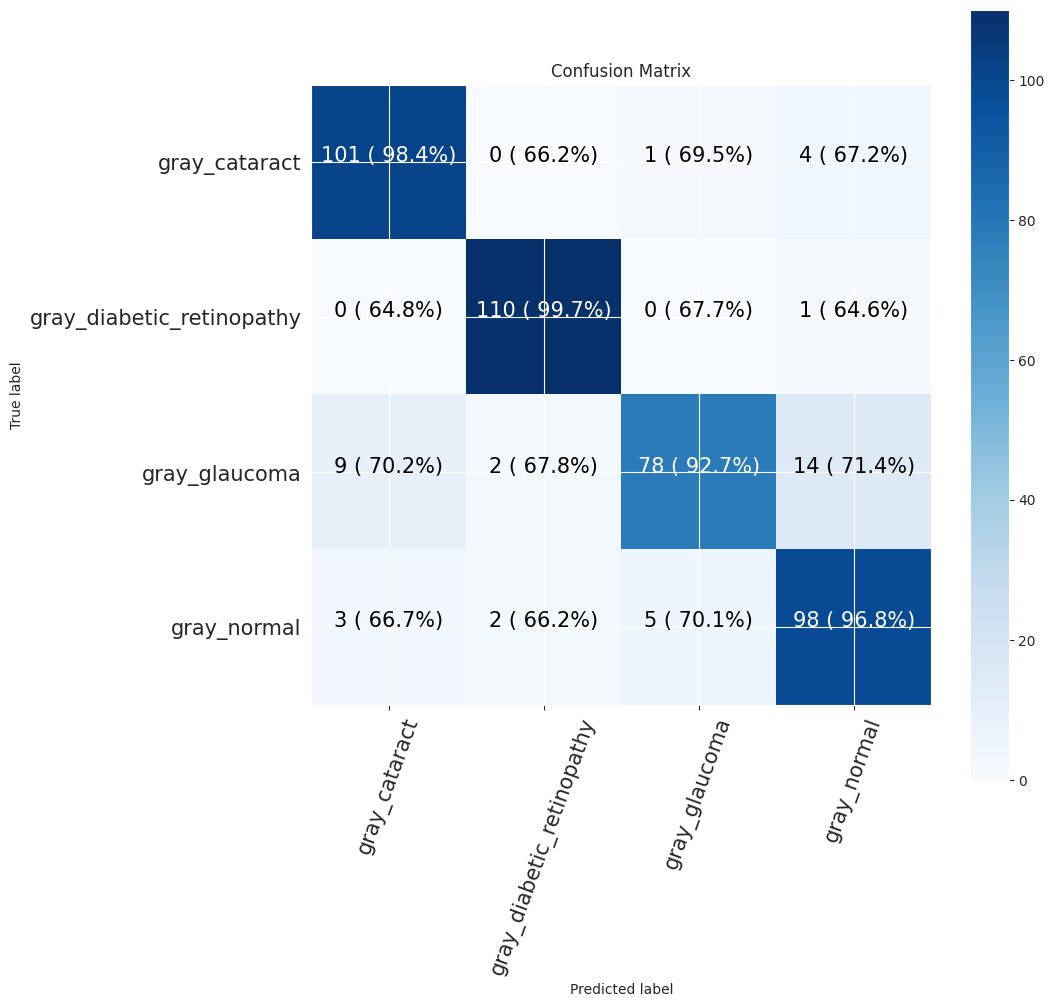

In [32]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


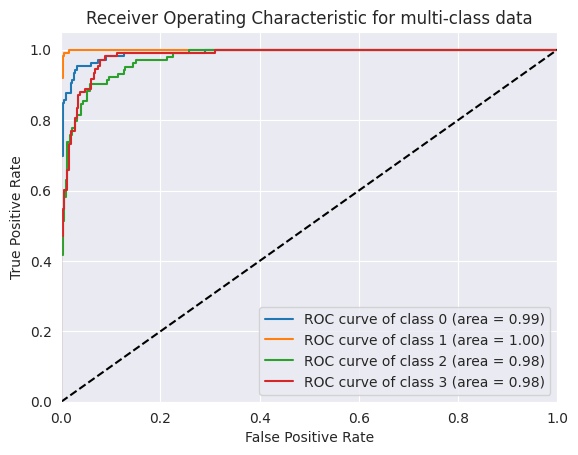

In [33]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [10]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

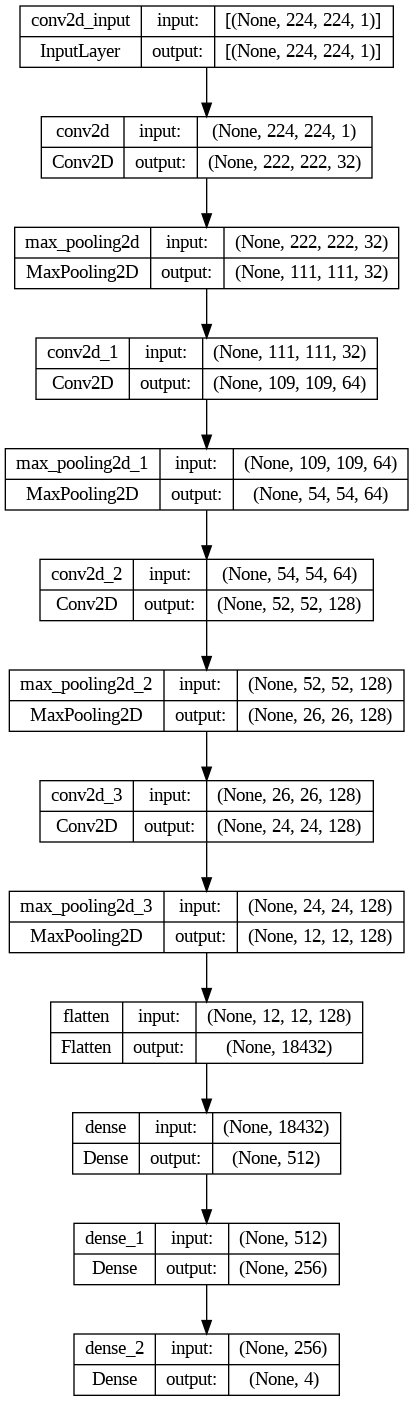

In [11]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [12]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 16s 23ms/step - loss: 1.6050 - accuracy: 0.5792 - val_loss: 0.7788 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 4s 19ms/step - loss: 0.6460 - accuracy: 0.7020 - val_loss: 0.7131 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 4s 20ms/step - loss: 0.6159 - accuracy: 0.7156 - val_loss: 0.6983 - val_accuracy: 0.7078 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 4s 20ms/step - loss: 0.7222 - accuracy: 0.6855 - val_loss: 0.7043 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 4s 20ms/step - loss: 0.6241 - accuracy: 0.7129 - val_loss: 0.6937 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 4s 19ms/step - loss: 0.5979 - accuracy: 0.7223 - val_loss: 0.6908 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 4s 19ms/s

CNN Evaluation

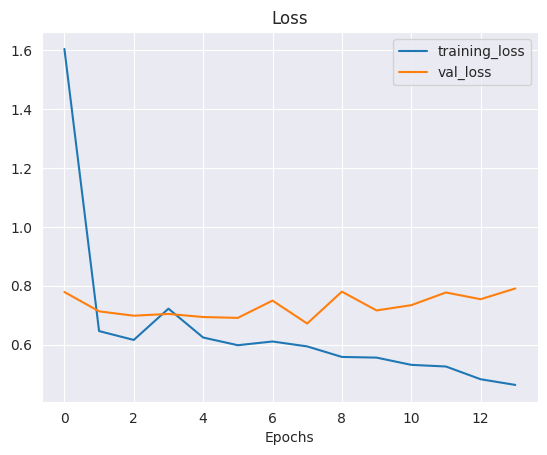

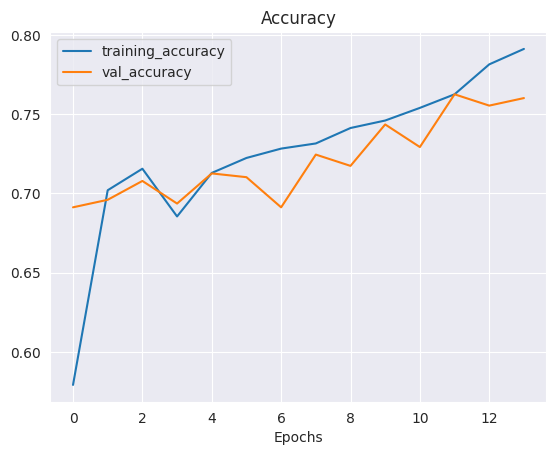

In [34]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       106
           1       1.00      1.00      1.00       111
           2       0.73      0.42      0.53       103
           3       0.72      0.97      0.83       108

    accuracy                           0.78       428
   macro avg       0.77      0.77      0.76       428
weighted avg       0.78      0.78      0.76       428

Specificity: [0.2056338028169014, 0.3501577287066246, 0.11168831168831168, 0.32507739938080493]
Mean Squared Error: : 0.13279606401920319
The average AUC-ROC is 0.9143879603328027


[0.8952380952380953,
 0.6656151419558359,
 0.7506775067750677,
 0.6925795053003534,
 0.6476190476190476,
 1.0,
 0.6991869918699187,
 0.607773851590106,
 0.7968253968253968,
 0.6750788643533123,
 0.8373983739837398,
 0.7102473498233216,
 0.6603174603174603,
 0.6593059936908517,
 0.7127371273712737,
 0.9893992932862191]

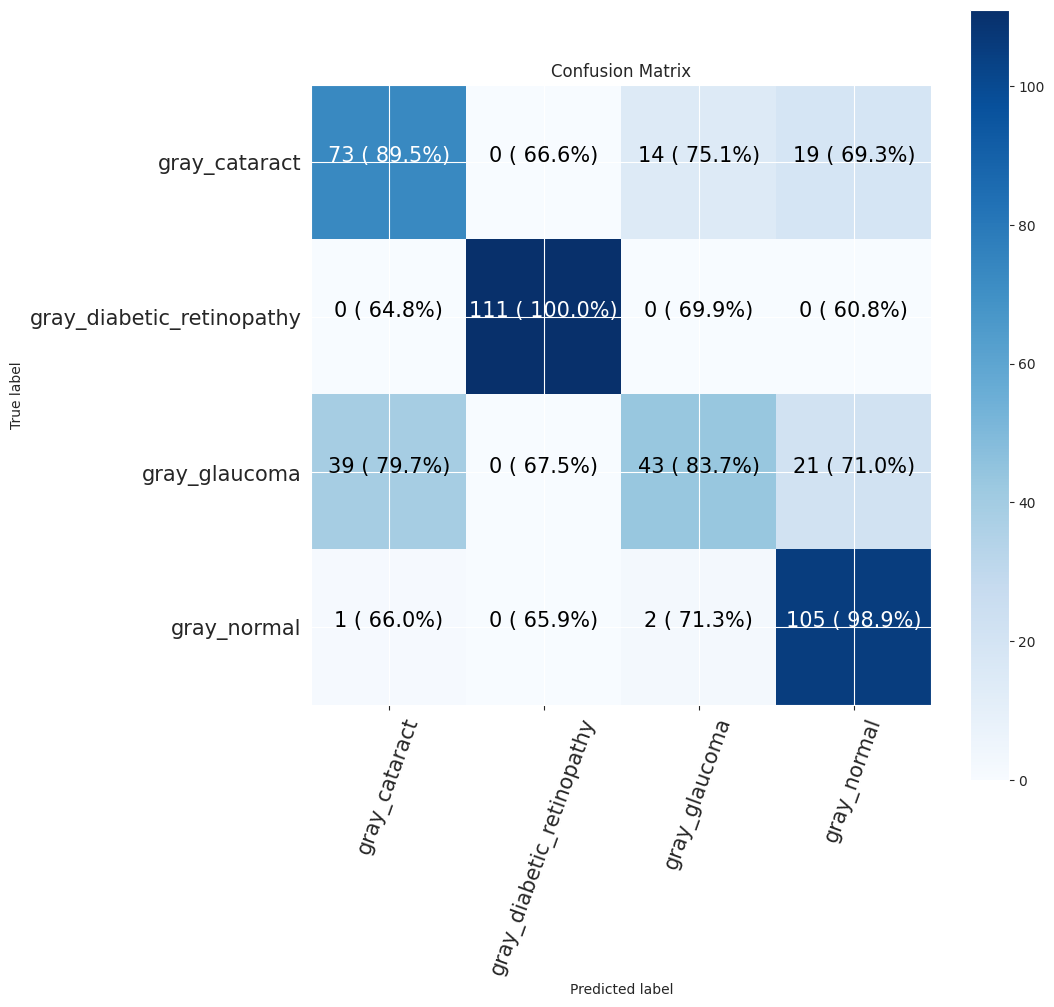

In [35]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


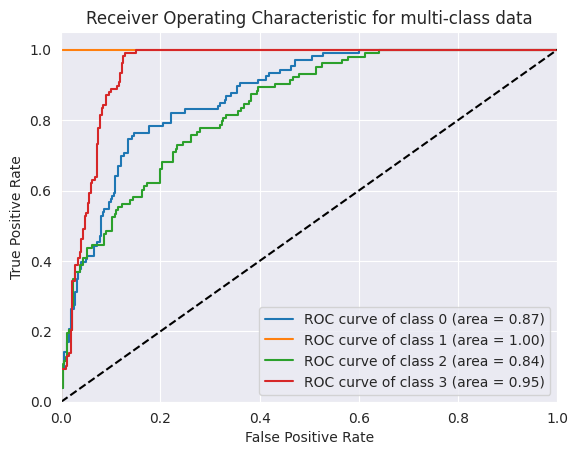

In [36]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [18]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 4100      
                                                           

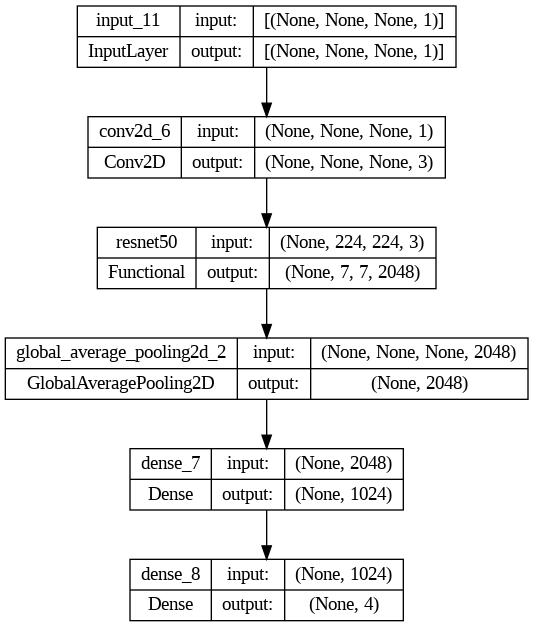

In [19]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [20]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [21]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 36s 144ms/step - loss: 0.6045 - accuracy: 0.7787 - val_loss: 0.3747 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 28s 133ms/step - loss: 0.3577 - accuracy: 0.8551 - val_loss: 0.3020 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 28s 134ms/step - loss: 0.3150 - accuracy: 0.8752 - val_loss: 0.3146 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 29s 136ms/step - loss: 0.2819 - accuracy: 0.8885 - val_loss: 0.3291 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 29s 136ms/step - loss: 0.2648 - accuracy: 0.8932 - val_loss: 0.3186 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 29s 137ms/step - loss: 0.2615 - accuracy: 0.8961 - val_loss: 0.3250 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 47ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       106
           1       0.99      1.00      1.00       111
           2       0.79      0.88      0.83       103
           3       0.90      0.83      0.87       108

    accuracy                           0.89       428
   macro avg       0.90      0.89      0.89       428
weighted avg       0.90      0.89      0.90       428

Specificity: [0.27002967359050445, 0.3501577287066246, 0.27002967359050445, 0.26627218934911245]
Mean Squared Error: : 0.10897710919380188
The average AUC-ROC is 0.9847456233386638


[0.9541284403669725,
 0.6645569620253164,
 0.6932907348242812,
 0.6920731707317073,
 0.6605504587155964,
 1.0,
 0.645367412140575,
 0.6615853658536586,
 0.7064220183486238,
 0.6740506329113924,
 0.9616613418530351,
 0.7012195121951219,
 0.6788990825688074,
 0.6613924050632911,
 0.6996805111821086,
 0.9451219512195121]

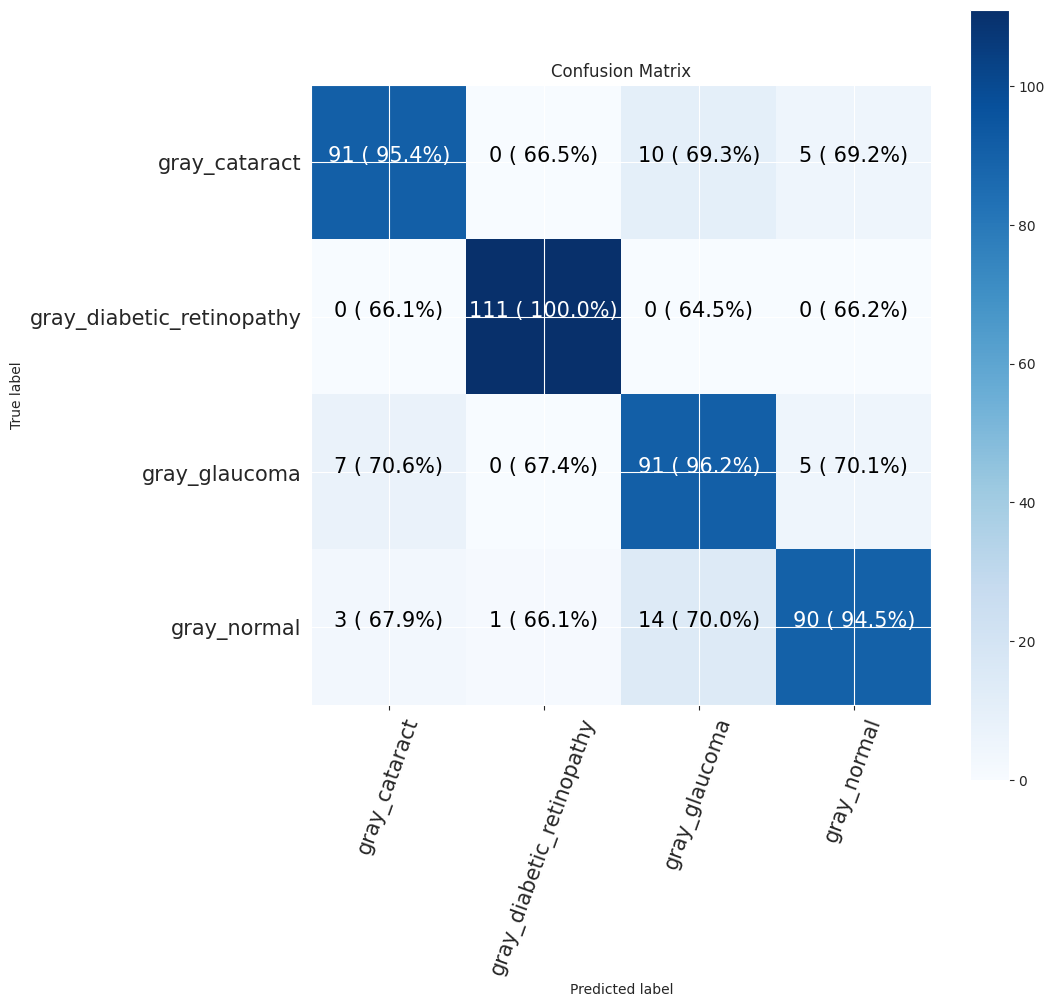

In [37]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


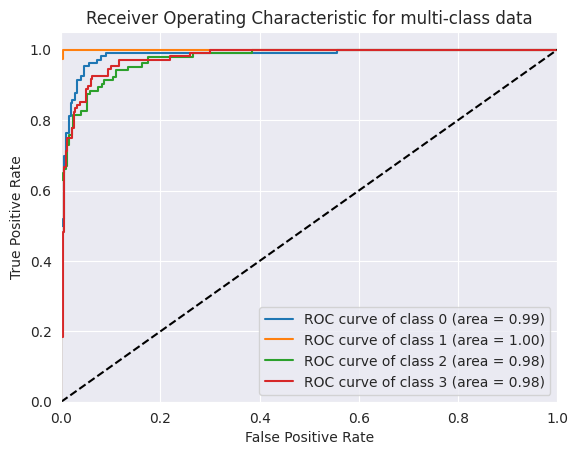

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [10]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100 

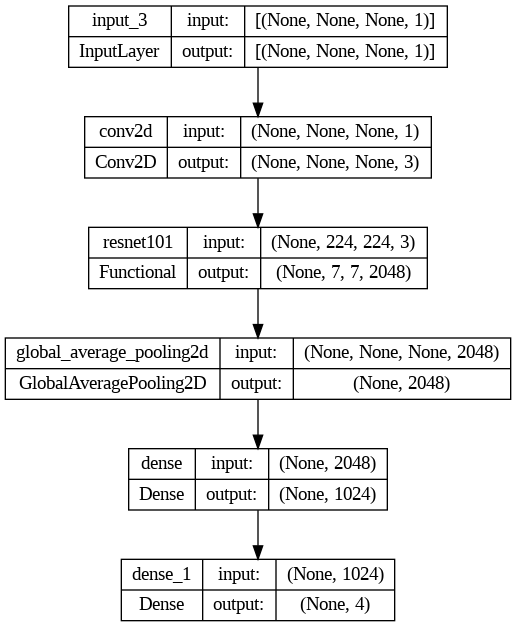

In [11]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [12]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 67s 233ms/step - loss: 0.6616 - accuracy: 0.7737 - val_loss: 0.8660 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 48s 226ms/step - loss: 0.3643 - accuracy: 0.8652 - val_loss: 0.3258 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 49s 229ms/step - loss: 0.3266 - accuracy: 0.8660 - val_loss: 0.3819 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 49s 229ms/step - loss: 0.2715 - accuracy: 0.8994 - val_loss: 0.3477 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 49s 229ms/step - loss: 0.2923 - accuracy: 0.8908 - val_loss: 0.2844 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 49s 229ms/step - loss: 0.2571 - accuracy: 0.9056 - val_loss: 0.3814 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 85ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       106
           1       0.99      0.99      0.99       111
           2       0.86      0.77      0.81       103
           3       0.86      0.89      0.88       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.296969696969697, 0.34591194968553457, 0.22636103151862463, 0.2891566265060241]
Mean Squared Error: : 0.10984621942043304
The average AUC-ROC is 0.9815924003297348


[0.9745222929936306,
 0.6656151419558359,
 0.6994047619047619,
 0.6750788643533123,
 0.6464968152866242,
 0.9968454258675079,
 0.6696428571428571,
 0.6529968454258676,
 0.7101910828025477,
 0.6782334384858044,
 0.9285714285714286,
 0.7097791798107256,
 0.6687898089171974,
 0.6593059936908517,
 0.7023809523809523,
 0.9621451104100947]

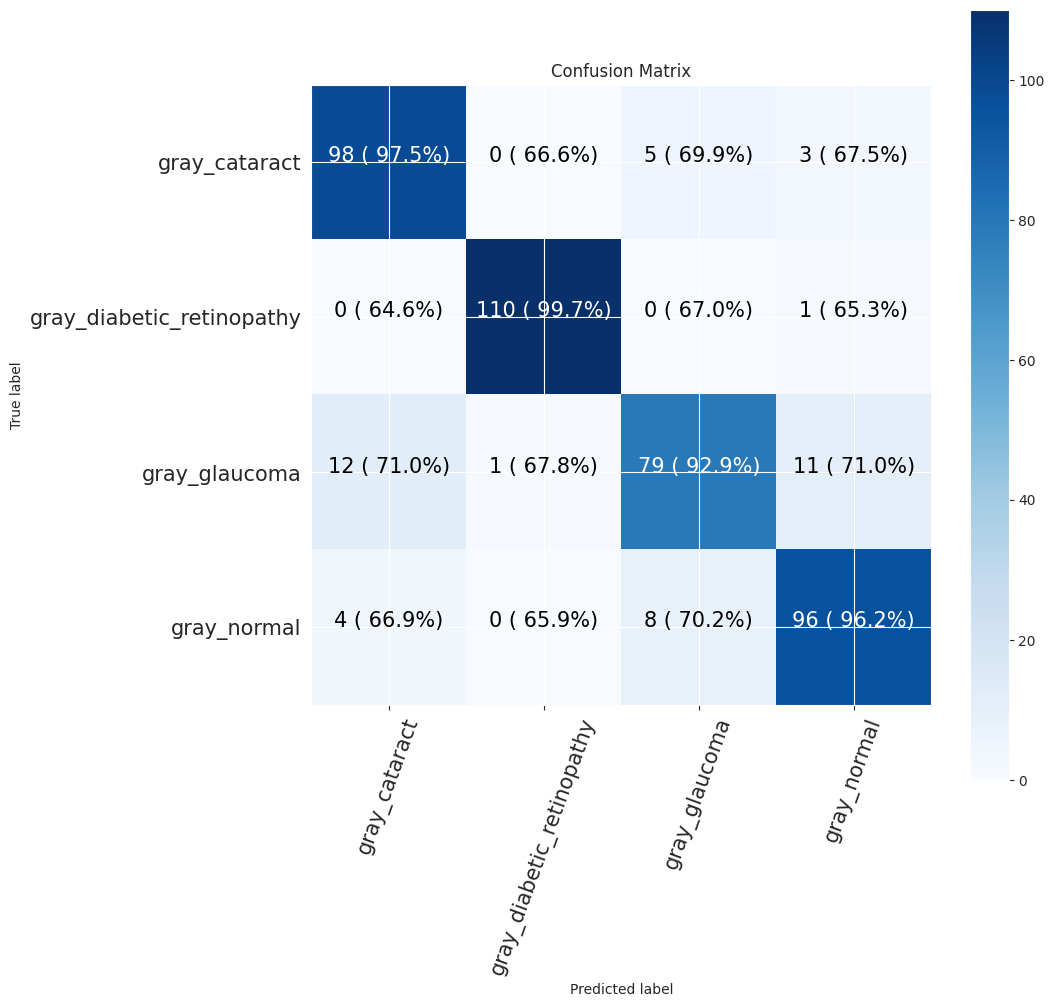

In [14]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


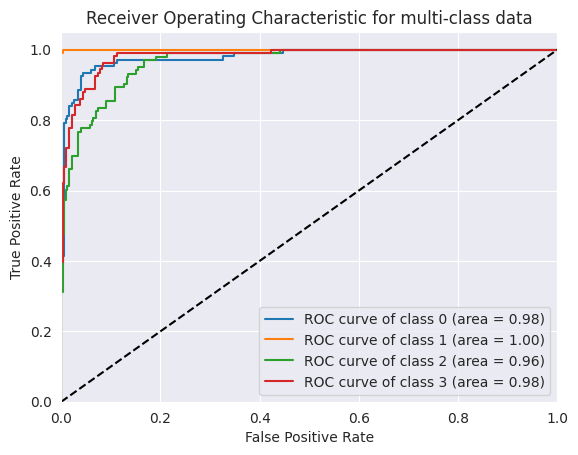

In [15]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [8]:
epoch = 20
batchsize = 32

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [24]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [25]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                49184     
                                                           

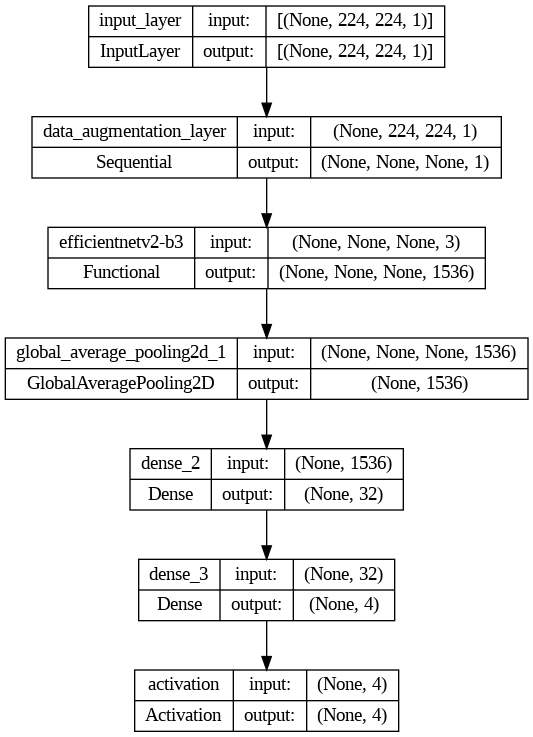

In [26]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [27]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [28]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 65s 501ms/step - loss: 0.6980 - accuracy: 0.7185 - val_loss: 0.5672 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 47s 442ms/step - loss: 0.5165 - accuracy: 0.8017 - val_loss: 0.5855 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 42s 396ms/step - loss: 0.4774 - accuracy: 0.8227 - val_loss: 0.5036 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 36s 341ms/step - loss: 0.4422 - accuracy: 0.8250 - val_loss: 0.4416 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 36s 338ms/step - loss: 0.4302 - accuracy: 0.8359 - val_loss: 0.4519 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 34s 318ms/step - loss: 0.4258 - accuracy: 0.8401 - val_loss: 0.4331 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

EfficientNetV2B3 Evaluation

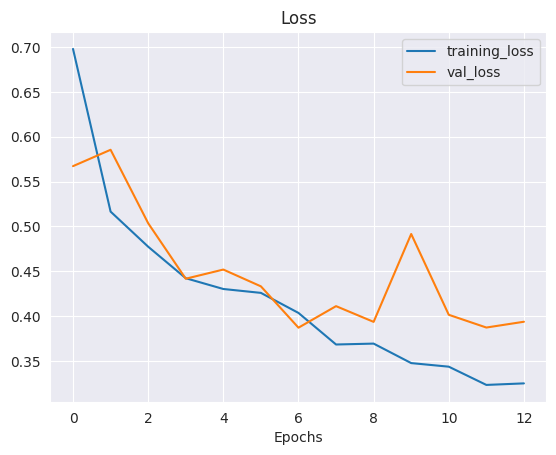

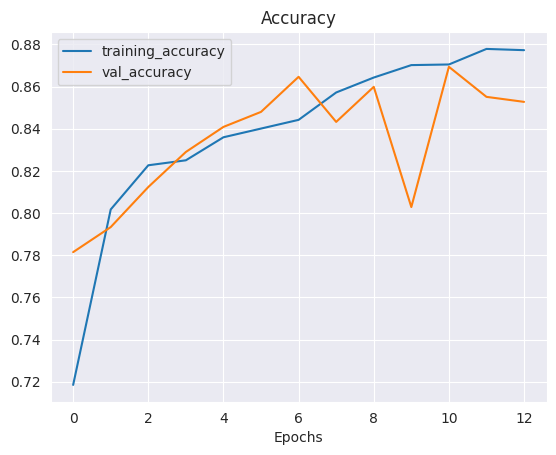

In [29]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 79ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       106
           1       0.99      0.95      0.97       111
           2       0.93      0.64      0.76       103
           3       0.78      0.94      0.85       108

    accuracy                           0.87       428
   macro avg       0.88      0.87      0.87       428
weighted avg       0.88      0.87      0.87       428

Specificity: [0.3009118541033435, 0.32919254658385094, 0.18232044198895028, 0.3128834355828221]
Mean Squared Error: : 0.11531797796487808
The average AUC-ROC is 0.9813532275663135


[0.9773462783171522,
 0.6697819314641744,
 0.7058823529411765,
 0.6632996632996633,
 0.6440129449838188,
 0.9844236760124611,
 0.6918767507002801,
 0.6363636363636364,
 0.7216828478964401,
 0.6791277258566978,
 0.896358543417367,
 0.7205387205387206,
 0.656957928802589,
 0.6666666666666666,
 0.7058823529411765,
 0.9797979797979798]

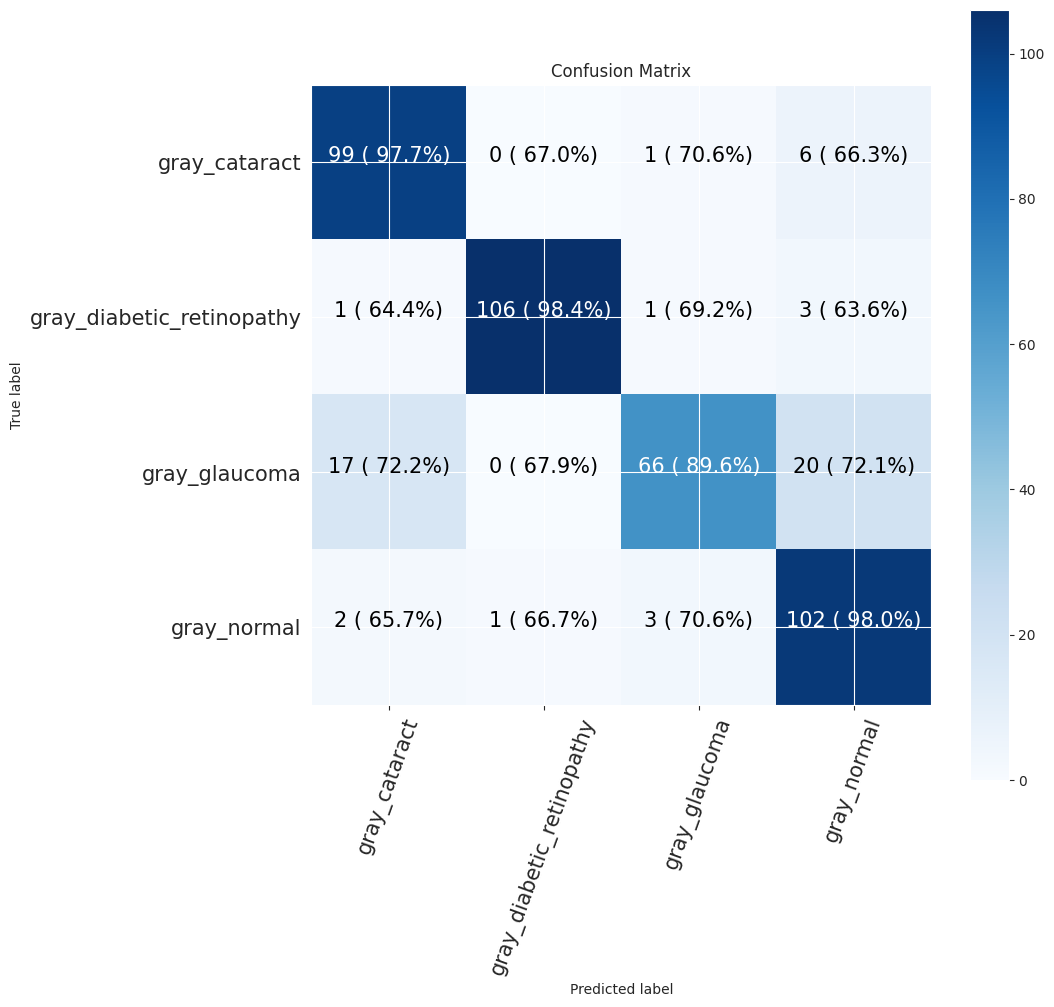

In [30]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


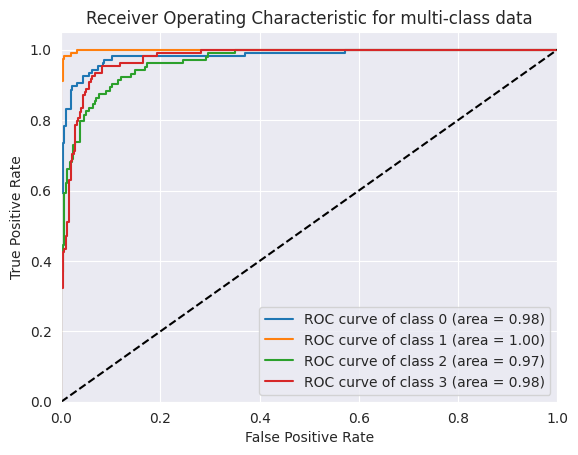

In [31]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [32]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

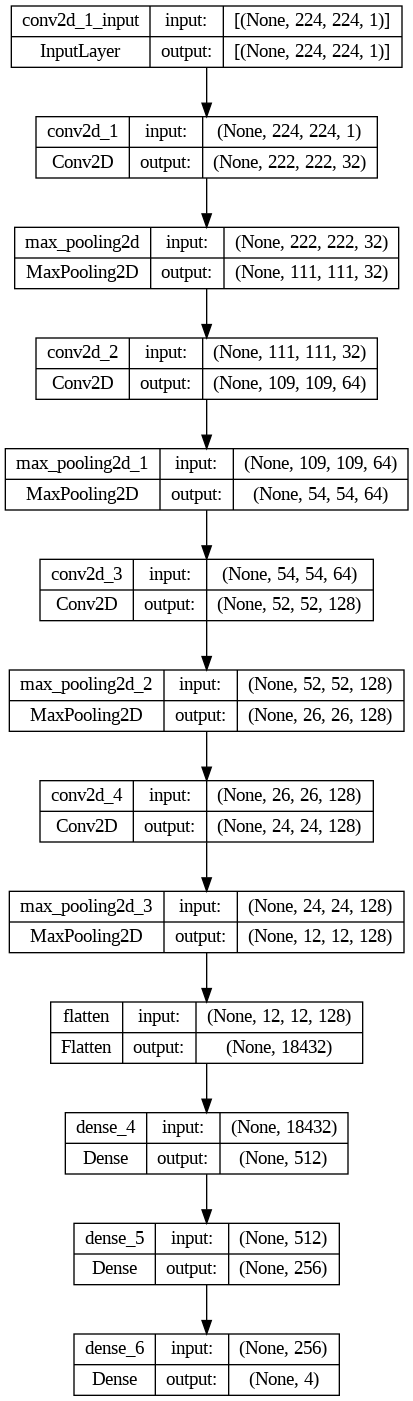

In [33]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [34]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [35]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 7s 44ms/step - loss: 2.3319 - accuracy: 0.5819 - val_loss: 0.6220 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 4s 36ms/step - loss: 0.6235 - accuracy: 0.7312 - val_loss: 0.6059 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 4s 36ms/step - loss: 0.5160 - accuracy: 0.7808 - val_loss: 0.5447 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 4s 36ms/step - loss: 0.4751 - accuracy: 0.7943 - val_loss: 0.6084 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 4s 36ms/step - loss: 0.4349 - accuracy: 0.8156 - val_loss: 0.4860 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 4s 36ms/step - loss: 0.3930 - accuracy: 0.8377 - val_loss: 0.4853 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 4s 36ms/st

CNN Evaluation

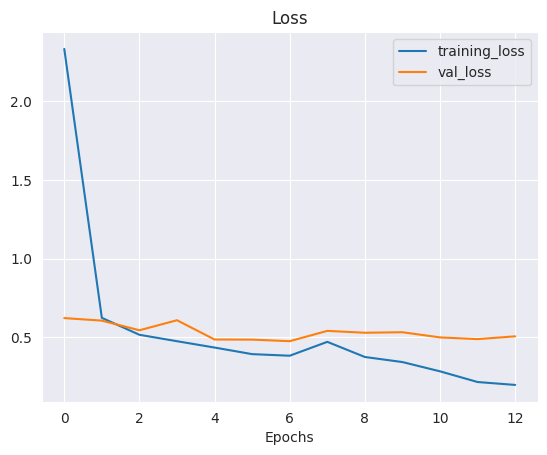

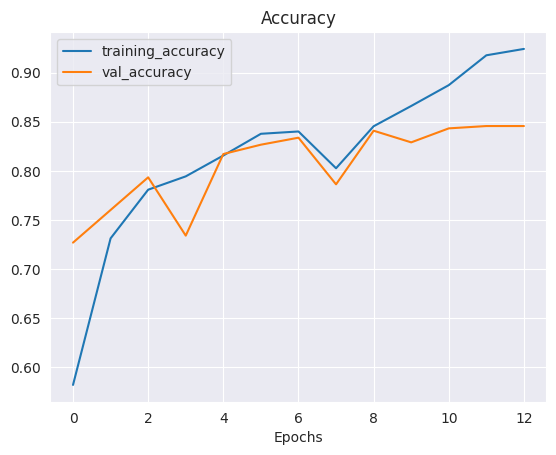

In [36]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       106
           1       0.98      1.00      0.99       111
           2       0.76      0.76      0.76       103
           3       0.82      0.87      0.84       108

    accuracy                           0.86       428
   macro avg       0.86      0.86      0.86       428
weighted avg       0.86      0.86      0.86       428

Specificity: [0.2478134110787172, 0.3501577287066246, 0.22285714285714286, 0.281437125748503]
Mean Squared Error: : 0.11585544794797897
The average AUC-ROC is 0.968488713582569


[0.9363636363636364,
 0.6634920634920635,
 0.7208588957055214,
 0.6805111821086262,
 0.6636363636363637,
 1.0,
 0.6595092024539877,
 0.645367412140575,
 0.7151515151515152,
 0.6761904761904762,
 0.9233128834355828,
 0.7188498402555911,
 0.6848484848484848,
 0.6603174603174603,
 0.696319018404908,
 0.9552715654952076]

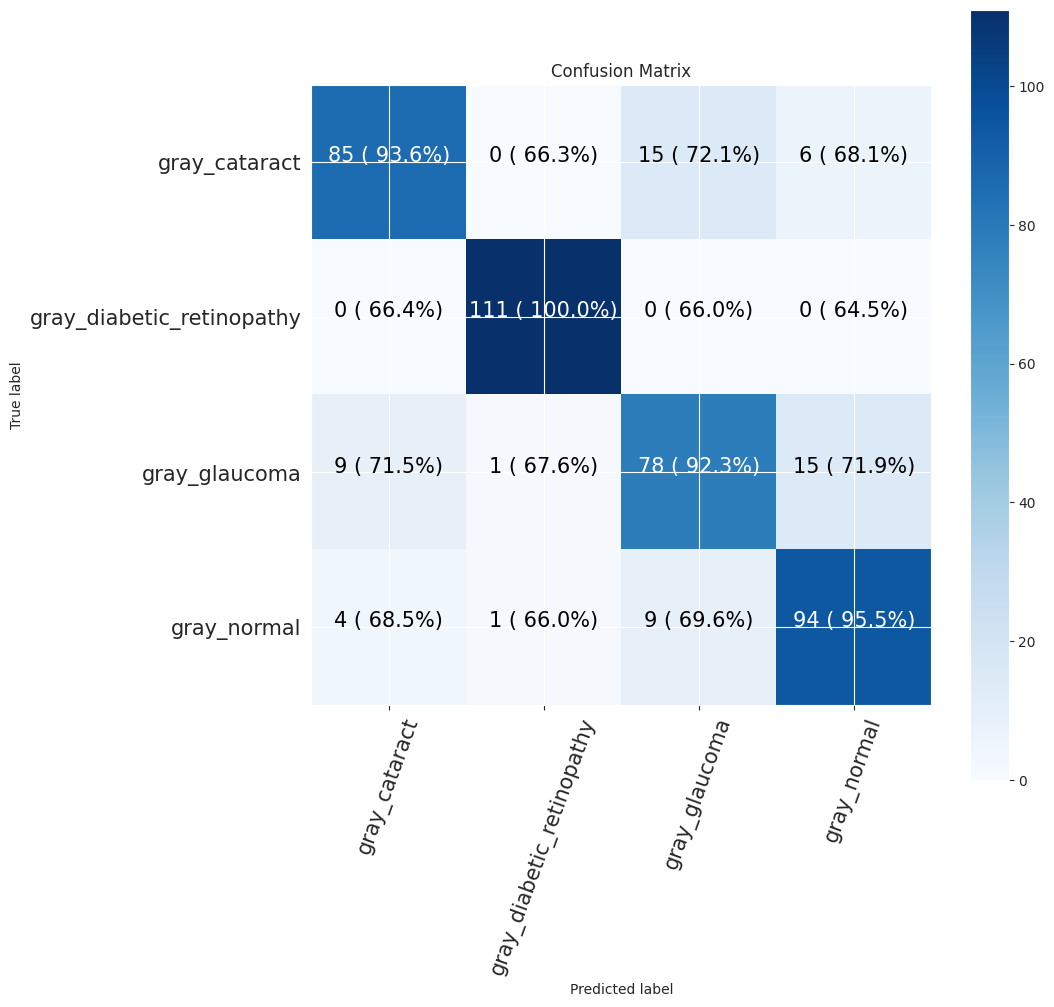

In [37]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


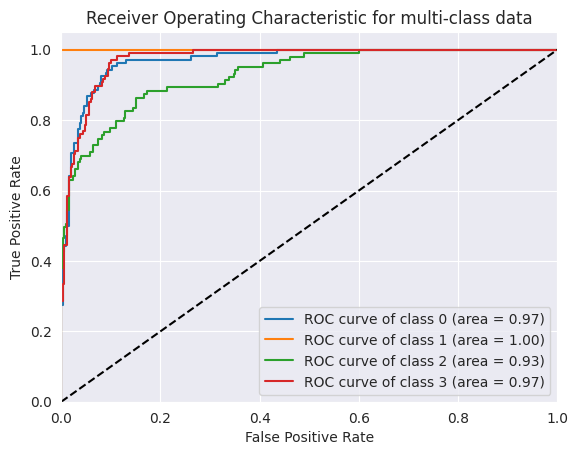

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [39]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 4100 

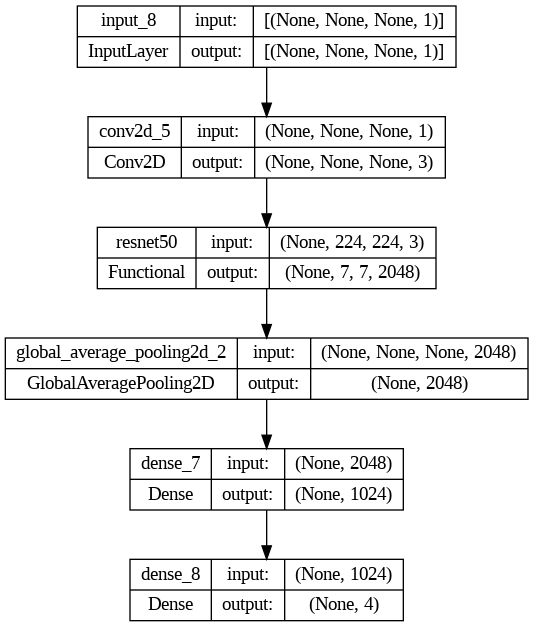

In [40]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [41]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [42]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 37s 292ms/step - loss: 0.6806 - accuracy: 0.7634 - val_loss: 0.4386 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 28s 267ms/step - loss: 0.3819 - accuracy: 0.8489 - val_loss: 0.4198 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 28s 264ms/step - loss: 0.3097 - accuracy: 0.8852 - val_loss: 0.3319 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 28s 265ms/step - loss: 0.2767 - accuracy: 0.8858 - val_loss: 0.2738 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 28s 265ms/step - loss: 0.2301 - accuracy: 0.9124 - val_loss: 0.3183 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 28s 265ms/step - loss: 0.2126 - accuracy: 0.9156 - val_loss: 0.2619 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       106
           1       0.99      1.00      1.00       111
           2       0.84      0.83      0.84       103
           3       0.88      0.89      0.88       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.2891566265060241, 0.3501577287066246, 0.25146198830409355, 0.2891566265060241]
Mean Squared Error: : 0.10539932548999786
The average AUC-ROC is 0.9888148400982649


[0.9690402476780186,
 0.6645569620253164,
 0.6993865030674846,
 0.6739811912225705,
 0.6563467492260062,
 1.0,
 0.6595092024539877,
 0.6520376175548589,
 0.6965944272445821,
 0.6772151898734177,
 0.9478527607361963,
 0.7115987460815048,
 0.6780185758513931,
 0.6582278481012658,
 0.6932515337423313,
 0.9623824451410659]

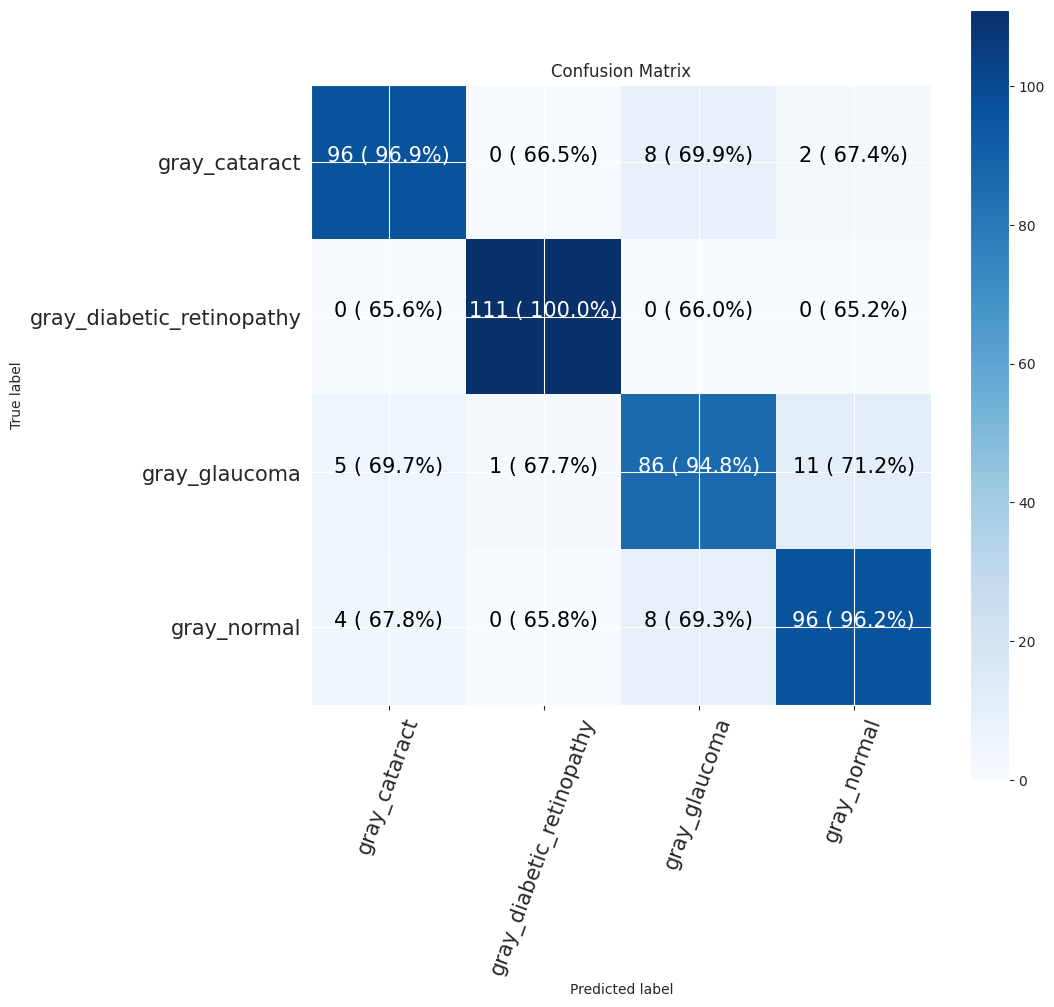

In [43]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


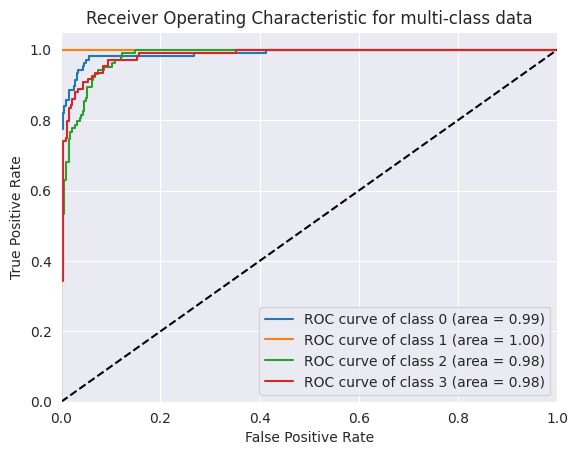

In [44]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [10]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100 

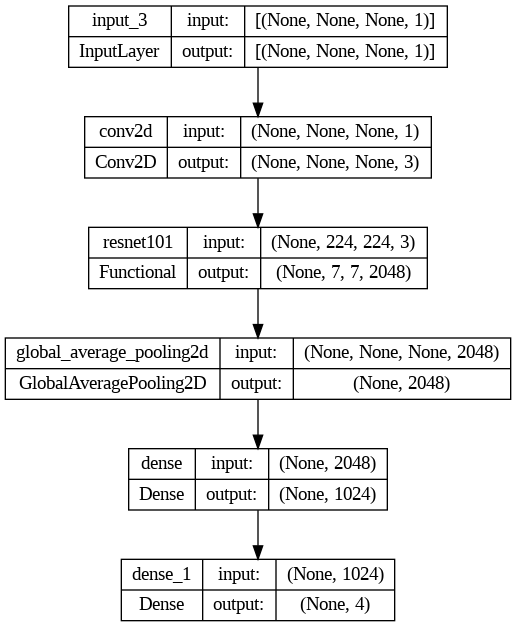

In [11]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [12]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [13]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 62s 430ms/step - loss: 0.7744 - accuracy: 0.7622 - val_loss: 0.3840 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 43s 403ms/step - loss: 0.3851 - accuracy: 0.8504 - val_loss: 0.5785 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 44s 411ms/step - loss: 0.3206 - accuracy: 0.8749 - val_loss: 0.3314 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 44s 410ms/step - loss: 0.2899 - accuracy: 0.8846 - val_loss: 0.4250 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 44s 410ms/step - loss: 0.2729 - accuracy: 0.8994 - val_loss: 0.4109 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 44s 411ms/step - loss: 0.2661 - accuracy: 0.8991 - val_loss: 0.2794 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       106
           1       0.99      0.98      0.99       111
           2       0.84      0.79      0.81       103
           3       0.88      0.87      0.87       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.3009118541033435, 0.34169278996865204, 0.2334293948126801, 0.281437125748503]
Mean Squared Error: : 0.11133989691734314
The average AUC-ROC is 0.9798024969661753


[0.9777070063694268,
 0.6666666666666666,
 0.6918429003021148,
 0.6791277258566978,
 0.6464968152866242,
 0.9937106918238994,
 0.6676737160120846,
 0.6573208722741433,
 0.7101910828025477,
 0.6792452830188679,
 0.9335347432024169,
 0.7071651090342679,
 0.6656050955414012,
 0.660377358490566,
 0.7069486404833837,
 0.956386292834891]

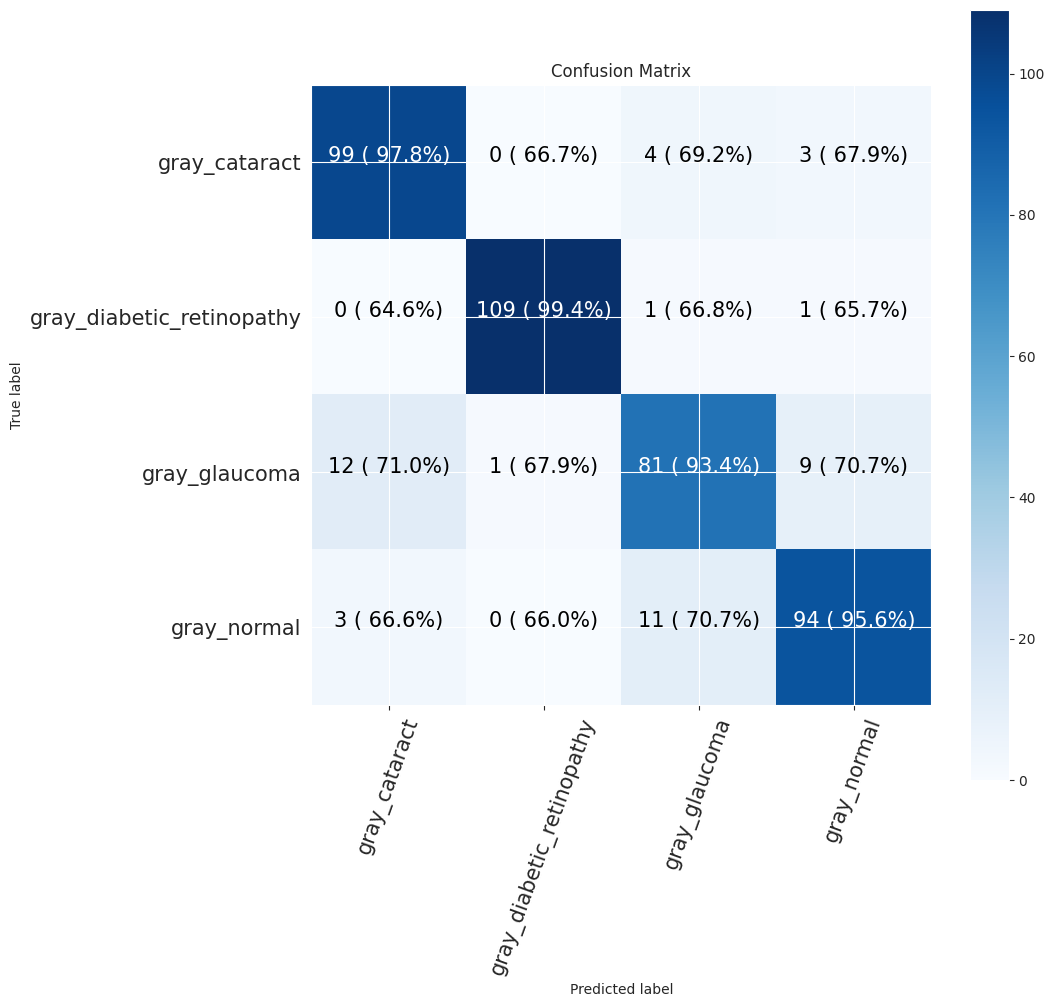

In [14]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


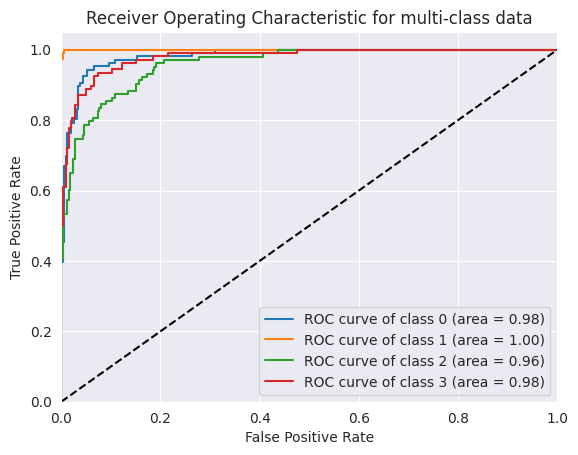

In [15]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [16]:
epoch = 20
batchsize = 64

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [18]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 3s 0us/step


In [19]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                49184     
                                                           

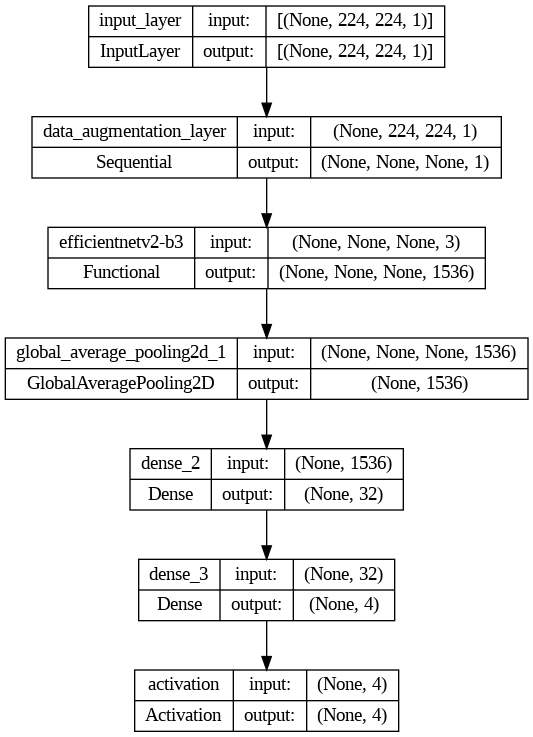

In [20]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [21]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [22]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 61s 927ms/step - loss: 0.7292 - accuracy: 0.7120 - val_loss: 0.6568 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 41s 768ms/step - loss: 0.5563 - accuracy: 0.7864 - val_loss: 0.5353 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 41s 786ms/step - loss: 0.4916 - accuracy: 0.8123 - val_loss: 0.4908 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 39s 732ms/step - loss: 0.4559 - accuracy: 0.8324 - val_loss: 0.4975 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 36s 676ms/step - loss: 0.4288 - accuracy: 0.8395 - val_loss: 0.4945 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 33s 620ms/step - loss: 0.4247 - accuracy: 0.8374 - val_loss: 0.4391 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 34s 631ms/st

EfficientNetV2B3 Evaluation

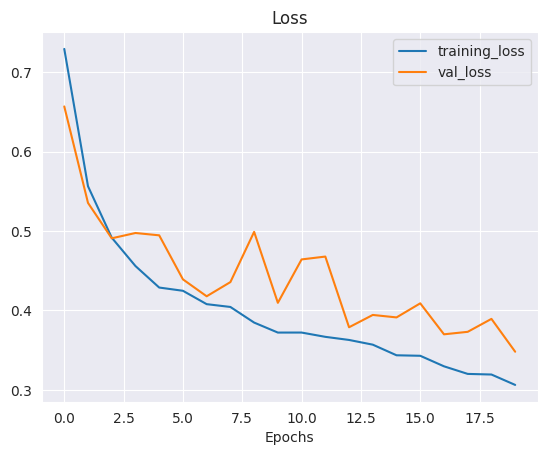

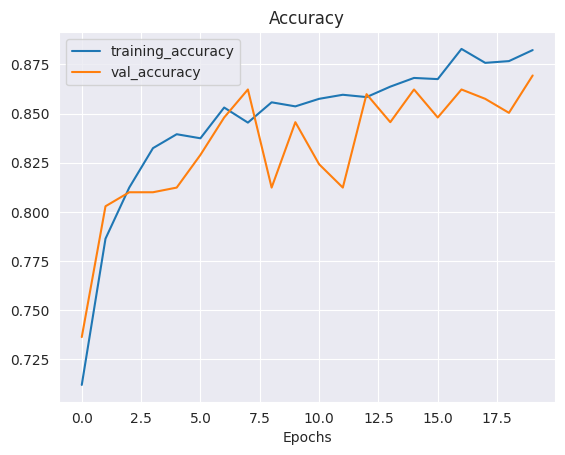

In [23]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 142ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       106
           1       0.96      0.97      0.96       111
           2       0.83      0.77      0.80       103
           3       0.83      0.88      0.85       108

    accuracy                           0.88       428
   macro avg       0.88      0.88      0.88       428
weighted avg       0.88      0.88      0.88       428

Specificity: [0.2891566265060241, 0.3375, 0.22636103151862463, 0.2852852852852853]
Mean Squared Error: : 0.11289222538471222
The average AUC-ROC is 0.9845961917499747


[0.9690402476780186,
 0.6634920634920635,
 0.7027027027027027,
 0.670926517571885,
 0.6563467492260062,
 0.9904761904761905,
 0.6696696696696697,
 0.6517571884984026,
 0.7058823529411765,
 0.6761904761904762,
 0.9279279279279279,
 0.7188498402555911,
 0.6687306501547987,
 0.6698412698412698,
 0.6996996996996997,
 0.9584664536741214]

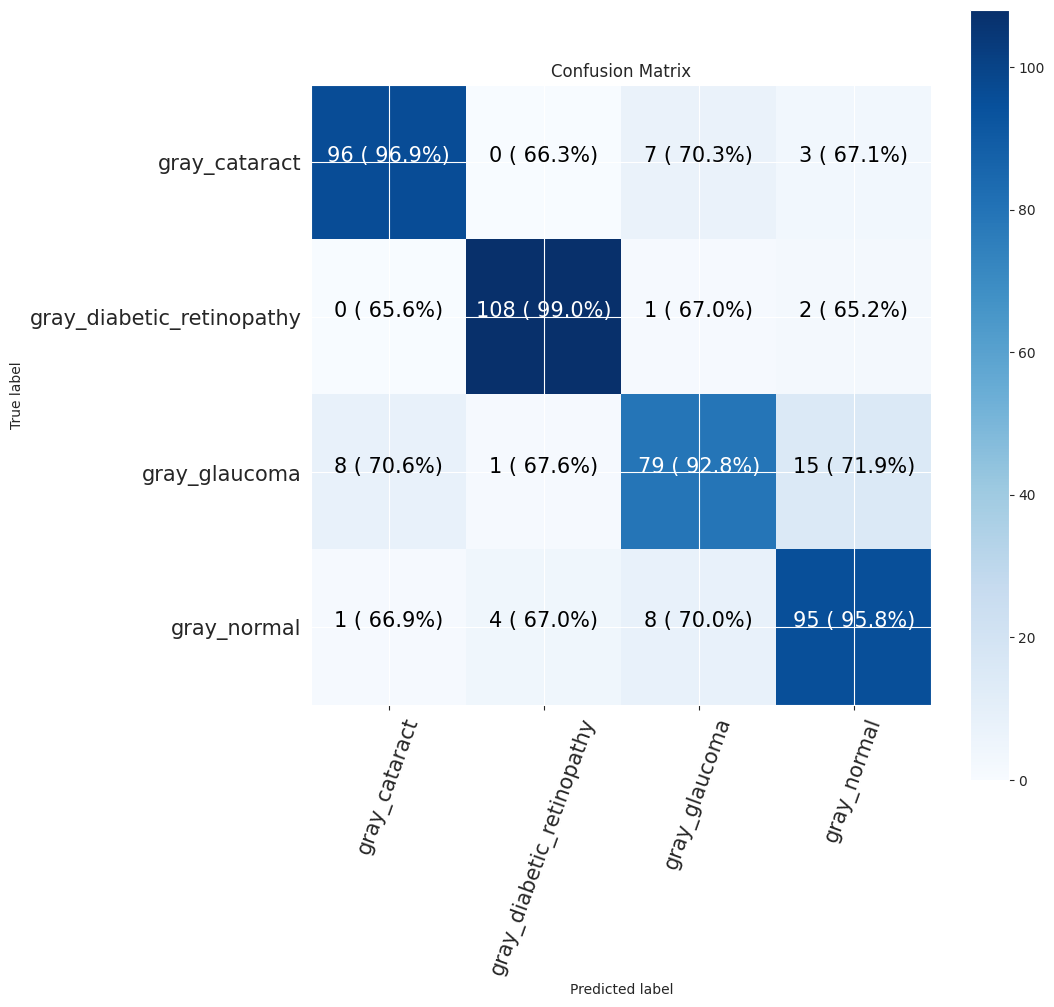

In [24]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


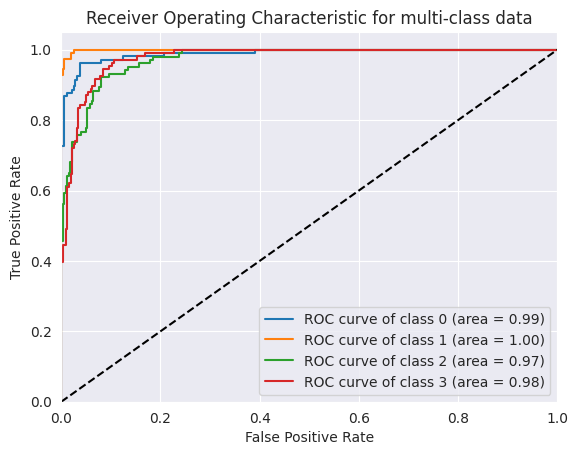

In [25]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [26]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

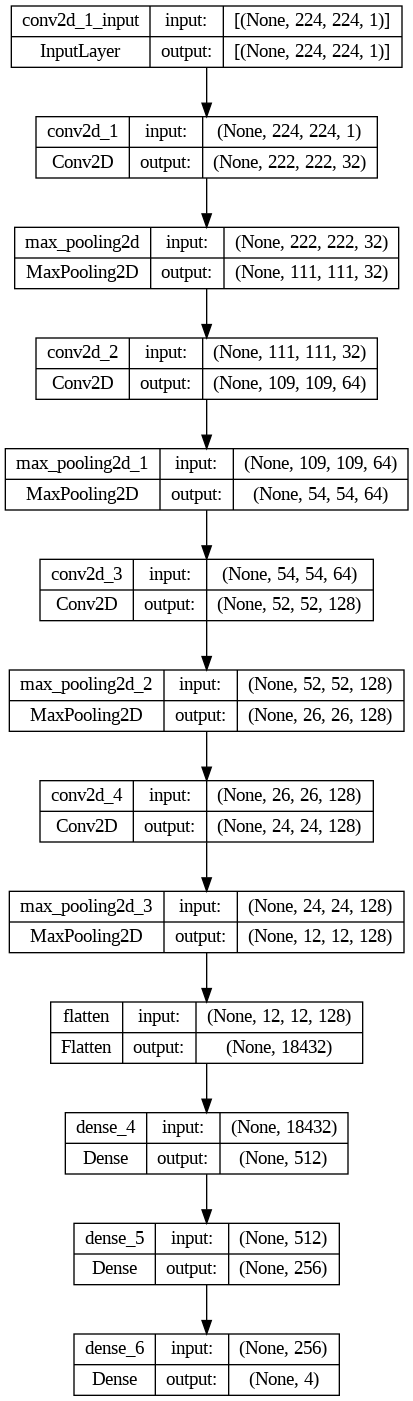

In [27]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [28]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [29]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 8s 93ms/step - loss: 3.2940 - accuracy: 0.5010 - val_loss: 0.8900 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 4s 65ms/step - loss: 0.6857 - accuracy: 0.7102 - val_loss: 0.6709 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 4s 65ms/step - loss: 0.5632 - accuracy: 0.7524 - val_loss: 0.5944 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 4s 65ms/step - loss: 0.5121 - accuracy: 0.7858 - val_loss: 0.5812 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 4s 65ms/step - loss: 0.5000 - accuracy: 0.7917 - val_loss: 0.5739 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4618 - accuracy: 0.8079 - val_loss: 0.5291 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 4s 65ms/step - loss: 0.4

CNN Evaluation

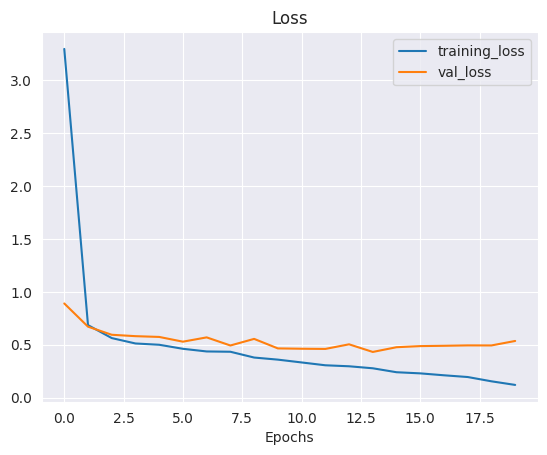

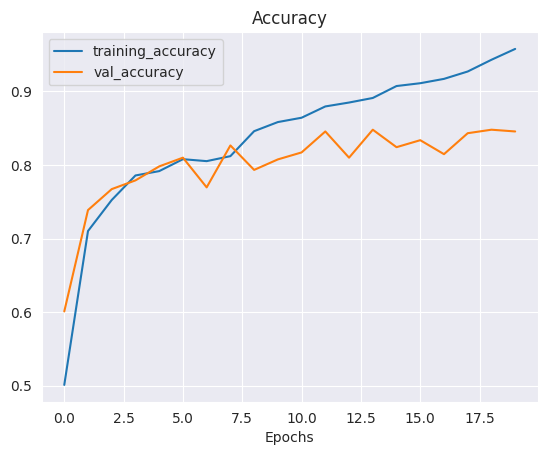

In [30]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.97      1.00      0.99       111
           2       0.85      0.71      0.77       103
           3       0.86      0.87      0.87       108

    accuracy                           0.88       428
   macro avg       0.88      0.88      0.87       428
weighted avg       0.88      0.88      0.88       428

Specificity: [0.296969696969697, 0.3501577287066246, 0.2056338028169014, 0.281437125748503]
Mean Squared Error: : 0.11208584904670715
The average AUC-ROC is 0.9732541196384396


[0.9741100323624595,
 0.6624203821656051,
 0.7076023391812866,
 0.6739811912225705,
 0.6407766990291263,
 1.0,
 0.6754385964912281,
 0.6520376175548589,
 0.7184466019417476,
 0.6751592356687898,
 0.9122807017543859,
 0.7178683385579937,
 0.6666666666666666,
 0.6624203821656051,
 0.7046783625730995,
 0.9561128526645768]

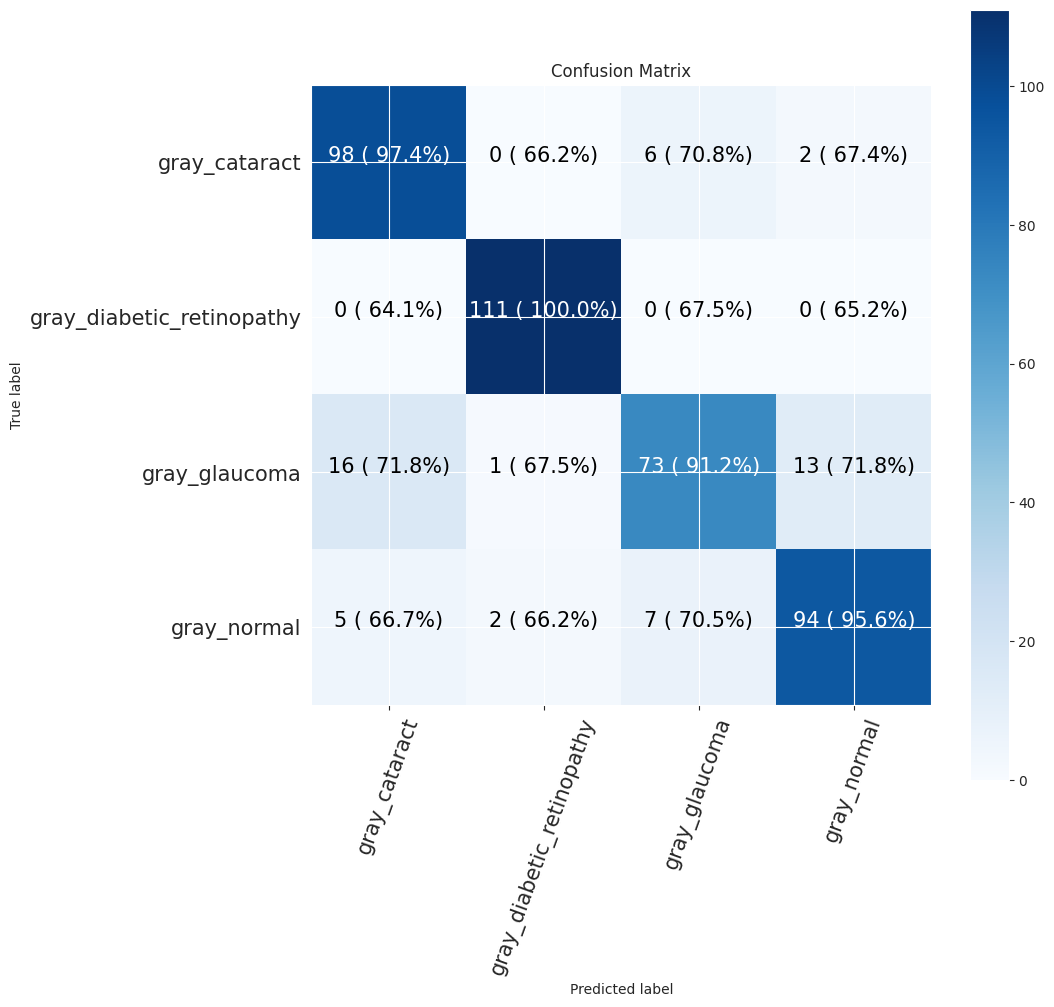

In [31]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


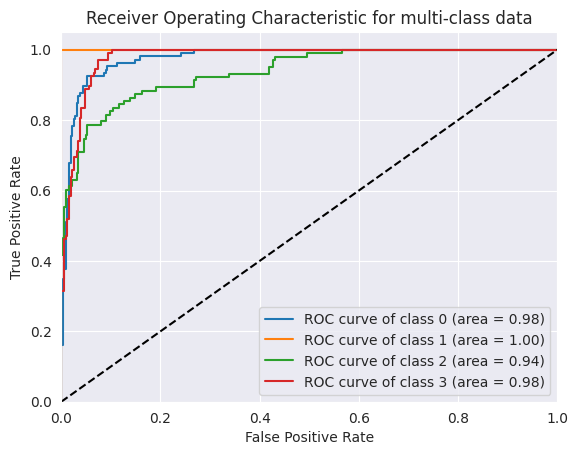

In [32]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [33]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 4100 

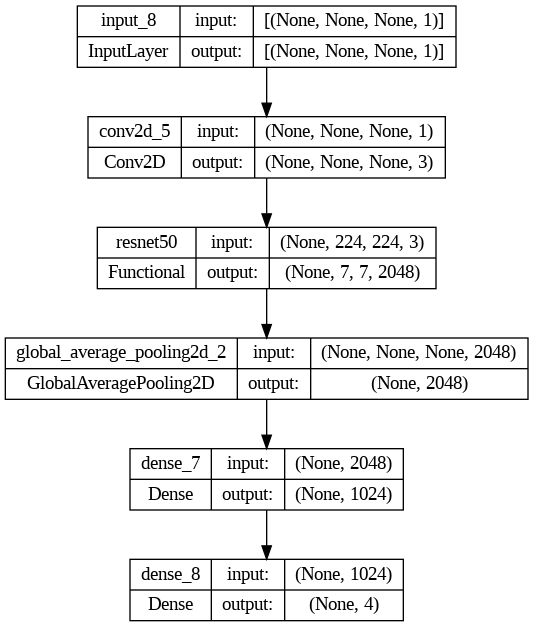

In [34]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [35]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [36]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 38s 585ms/step - loss: 0.9367 - accuracy: 0.7156 - val_loss: 0.4714 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 26s 485ms/step - loss: 0.3984 - accuracy: 0.8498 - val_loss: 0.3611 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 26s 481ms/step - loss: 0.3347 - accuracy: 0.8740 - val_loss: 0.3396 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 26s 483ms/step - loss: 0.2828 - accuracy: 0.8944 - val_loss: 0.3024 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 26s 484ms/step - loss: 0.2683 - accuracy: 0.8902 - val_loss: 0.3242 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 26s 483ms/step - loss: 0.2201 - accuracy: 0.9171 - val_loss: 0.2782 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 26s 483ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 169ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       106
           1       1.00      1.00      1.00       111
           2       0.73      0.92      0.81       103
           3       0.93      0.71      0.81       108

    accuracy                           0.88       428
   macro avg       0.89      0.88      0.88       428
weighted avg       0.90      0.88      0.88       428

Specificity: [0.2852852852852853, 0.3501577287066246, 0.2852852852852853, 0.21937321937321938]
Mean Squared Error: : 0.10959668457508087
The average AUC-ROC is 0.9852632682242186


[0.9661538461538461,
 0.6656151419558359,
 0.6734006734006734,
 0.6985507246376812,
 0.6584615384615384,
 1.0,
 0.6262626262626263,
 0.6782608695652174,
 0.6953846153846154,
 0.6750788643533123,
 0.9730639730639731,
 0.7130434782608696,
 0.68,
 0.6593059936908517,
 0.7272727272727273,
 0.9101449275362319]

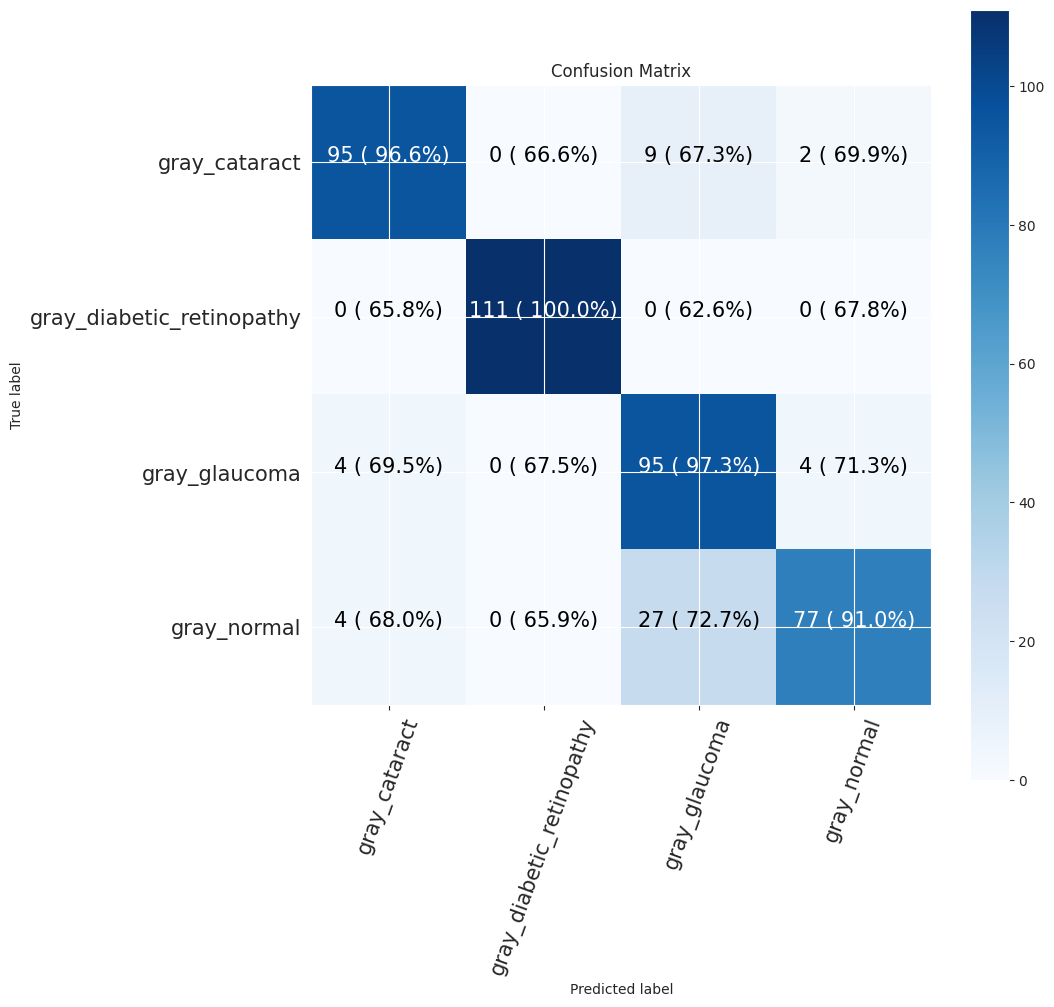

In [37]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


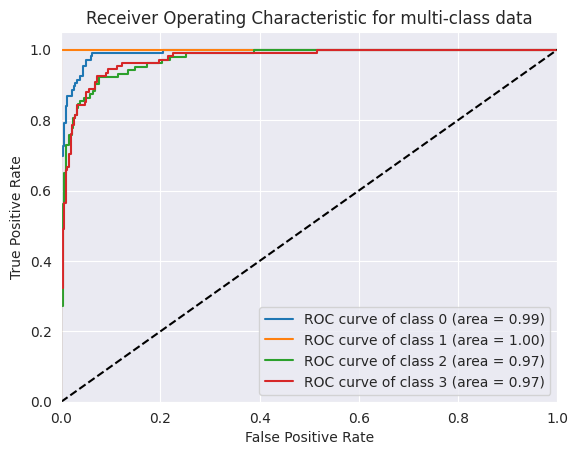

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [39]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_10 (Dense)            (None, 4)                 4100      
                                                           

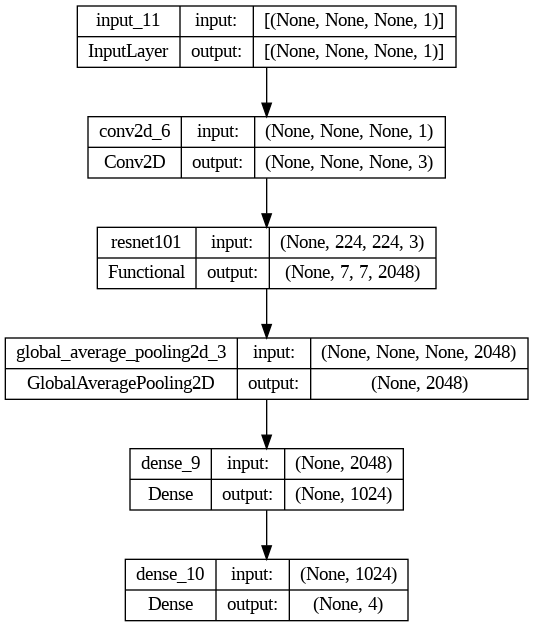

In [40]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [41]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [42]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 50s 814ms/step - loss: 0.8218 - accuracy: 0.7386 - val_loss: 0.4174 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 41s 776ms/step - loss: 0.3872 - accuracy: 0.8486 - val_loss: 0.3489 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 41s 777ms/step - loss: 0.3204 - accuracy: 0.8820 - val_loss: 0.3362 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 41s 778ms/step - loss: 0.2979 - accuracy: 0.8932 - val_loss: 0.3075 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 41s 777ms/step - loss: 0.2541 - accuracy: 0.9056 - val_loss: 0.2849 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 41s 777ms/step - loss: 0.2528 - accuracy: 0.9073 - val_loss: 0.2617 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 41s 777ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 280ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       106
           1       1.00      0.99      1.00       111
           2       0.86      0.81      0.83       103
           3       0.83      0.86      0.85       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.90      0.89      0.89       428

Specificity: [0.2930513595166163, 0.34591194968553457, 0.24057971014492754, 0.27761194029850744]
Mean Squared Error: : 0.10991194099187851
The average AUC-ROC is 0.983536234065222


[0.9717868338557993,
 0.6666666666666666,
 0.6918429003021148,
 0.680379746835443,
 0.6520376175548589,
 0.9968553459119497,
 0.6646525679758308,
 0.6518987341772152,
 0.6990595611285266,
 0.6761006289308176,
 0.9395770392749244,
 0.7151898734177216,
 0.677115987460815,
 0.660377358490566,
 0.7039274924471299,
 0.9525316455696202]

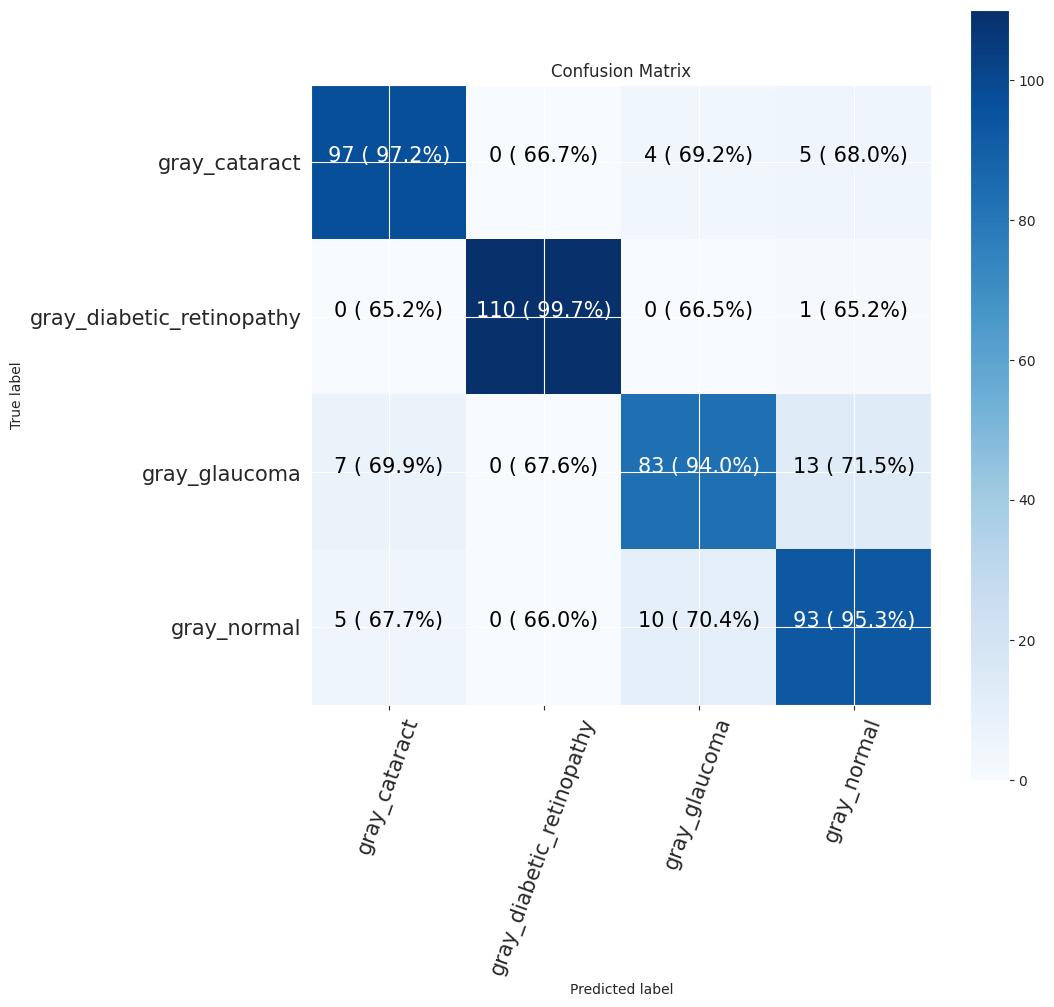

In [43]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


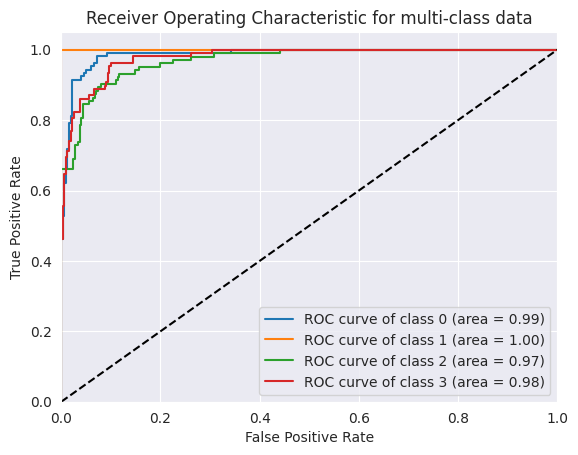

In [44]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()